# Solving systems with GD
Focusing on symmetric positive definite (SPD) systems, such as the ones arising in Gaussian Processes.
$$
(K + \sigma^2 I) \alpha = y
$$
$(K + \sigma^2 I)$ may be ill-conditioned (realistic condition numbers in the order of $10^2$ to $10^4$).
We wiil compare the performance of the following solvers:

1. Gradient Descent (GD; currently not stochastic)
3. Conjugate Gradient (CG; iterative solver; using the class I built for the GP project)
4. Cholesky Decomposition (direct solver)



In [1]:
import torch
import torch.nn as nn
from torch.optim import Adam
import matplotlib.pyplot as plt


In [2]:
import numpy as np
def generate_well_conditioned_spd(n, condition_number=10, random_state=None, return_tensor=True):
    """
    Generate a well-conditioned, symmetric positive definite matrix.

    Parameters:
    n (int): Size of the square matrix
    condition_number (float): Desired condition number (default: 10)
    random_state (int or None): Seed for random number generator

    Returns:
    numpy.ndarray: A well-conditioned SPD matrix
    """
    if random_state is not None:
        np.random.seed(random_state)

    # Generate random orthogonal matrix
    Q, _ = np.linalg.qr(np.random.randn(n, n))

    # Generate eigenvalues
    lambda_min = 1
    lambda_max = condition_number
    lambdas = np.exp(np.linspace(np.log(lambda_min), np.log(lambda_max), n))

    # Create diagonal matrix of eigenvalues
    D = np.diag(lambdas)

    # Create SPD matrix
    A = Q @ D @ Q.T

    if return_tensor:
        A = torch.tensor(A, dtype=torch.float32)

    return A

In [93]:
# Example with RBF kernel
def rbf_kernel(X, lengthscale=1.0):
    """Compute RBF kernel matrix"""
    # Compute pairwise distances
    dist_matrix = torch.cdist(X.unsqueeze(0), X.unsqueeze(0)).squeeze(0)
    # Compute kernel matrix
    K = torch.exp(-0.5 * dist_matrix**2 / lengthscale**2)
    return K

In [105]:
# generate synthetic data
SYSTEM_MATRIX_TYPE = "from_condition_number" # "from_condition_number" or RBF
N = 100
X = torch.linspace(-5, 5, N).reshape(-1, 1).to(torch.float64)
if SYSTEM_MATRIX_TYPE == "RBF":
    SIGMA_SQ = 0.1
    K = (rbf_kernel(X) + SIGMA_SQ * torch.eye(N)).to(torch.float64)
elif SYSTEM_MATRIX_TYPE == "from_condition_number":
    CONDITION_NUMBER = 10
    K = generate_well_conditioned_spd(N, condition_number=CONDITION_NUMBER, random_state=42).to(torch.float64)
    # add small diagonal noise to K 
    K = K + 1e-6 * torch.eye(N).to(torch.float64)
y = torch.sin(X).reshape(-1).to(torch.float64) + torch.randn(N) * 0.1


In [106]:
y.shape

torch.Size([100])

In [107]:
# assert that the system matrix is SPD 
assert torch.all(torch.linalg.eigvalsh(K) > 0), "not all eigenvalues are positive"
assert torch.allclose(K, K.T), "K is not symmetric"


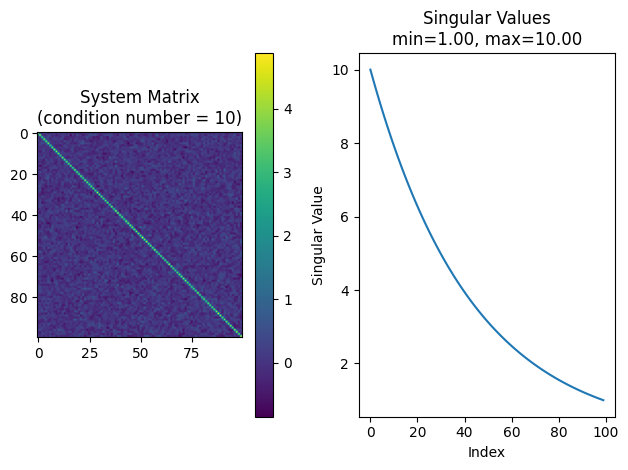

In [108]:
# run an SVD on K 
U, S, V = torch.linalg.svd(K)

# create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6.4, 4.8))

# plot system matrix
im = ax1.imshow(K.numpy())
plt.colorbar(im, ax=ax1)
ax1.set_title(f'System Matrix\n(condition number = {CONDITION_NUMBER})')

# plot singular values
ax2.plot(S)
ax2.set_title(f'Singular Values\nmin={S[-1]:.2f}, max={S[0]:.2f}')
ax2.set_xlabel('Index')
ax2.set_ylabel('Singular Value')

plt.tight_layout()
plt.show()

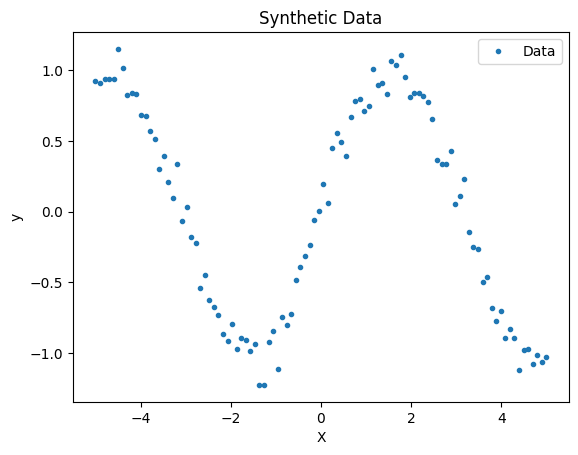

In [109]:
# plot the data 
plt.figure()
plt.plot(X, y, label='Data', linestyle="none", marker=".")
plt.title('Synthetic Data')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()

### start with the Cholesky solver 
Direct and exact

In [110]:
# solve the system with Cholesky 
L = torch.linalg.cholesky(K)

In [111]:
alpha_cholesky = torch.cholesky_solve(y.unsqueeze(-1), L).squeeze(-1)
cholesky_mse = torch.mean((K @ alpha_cholesky - y)**2).item()
print(f"Cholesky MSE: {cholesky_mse:.6e}")


Cholesky MSE: 2.034552e-31


This is CG code copied from Dan's cg.py file dealing with complex numbers.

In [123]:
class ConjugateGradients:
    """
    Conjugate Gradients solver for linear systems Ax = b with symmetric positive definite A.
    Args:
        A (torch.Tensor): Symmetric positive definite matrix
        b (torch.Tensor): Right-hand side vector
        x0 (torch.Tensor): Initial guess
        tol (float): Tolerance for early stopping
        max_iter (int): Maximum number of iterations
        early_stopping (bool): Whether to stop early if residual is below tolerance

    Returns:
        x (torch.Tensor): Solution to the linear system
    """

    def __init__(self, A_apply_function, b, x0, tol=1e-6, early_stopping=True, max_iter=None):
        # Get device from input tensors
        device = b.device

        if isinstance(A_apply_function, torch.Tensor):
            # if A_apply_function is a matrix, we use it directly
            self.A_apply_function = lambda x: A_apply_function @ x
        elif callable(A_apply_function):
            # if A_apply_function is a function, we use it as is
            self.A_apply_function = A_apply_function
        else:
            raise ValueError("A_apply_function must be a torch.Tensor or a callable")
        if isinstance(A_apply_function, torch.Tensor):
            dtype = A_apply_function.dtype
        else:
            dtype = torch.complex128 # for the FFTs in the complex case
        
        self.b = b.to(dtype=dtype, device=device)
        self.x0 = x0.to(dtype=dtype, device=device)
        self.tol = tol
        self.div_eps = 1e-32 # small value to prevent division by zero, can nan without it
        # Set max_iter to either the provided value or 2n as a default
        self.max_iter = max_iter if max_iter is not None else 2 * len(self.b)
        self.early_stopping = early_stopping
        self.iters_completed = None
        self.solution_history = []
        print("="*5 + " CG Solver initialized " + "="*5)
        print(f"Using {dtype} precision for CG matrix-vector products!")
        print(f"Using {device} device!")
        print(f"System size: {len(self.b)}, Max iterations: {self.max_iter}")
        if self.early_stopping:
            print(f"Early stopping enabled, tolerance: {self.tol}")
        else:
            print("Early stopping disabled")
        print("="*25)
    def solve(self):
        """Solve the linear system using Conjugate Gradients.
        Returns:
            torch.Tensor: Solution to the linear system
        """
        x = self.x0  # initial guess
        r = self.b - self.A_apply_function(x)  # initial residual
        p = r  # initial search direction
        
        for i in range(self.max_iter):
            # TODO: more comments on ops
            Ap = self.A_apply_function(p)  # appears twice, in alpha and next residual
            r_norm = torch.conj(r.T) @ r
            
            # Check convergence using the user-specified tolerance
            # using absolute to avoid complex number issues, also sqrt beause dot product is norm squared
            if self.early_stopping and torch.sqrt(abs(r_norm)) < self.tol:
                print(f"Converged in {i} iterations: Residual norm {torch.sqrt(abs(r_norm))} below tolerance {self.tol}")
                break

            alpha_k = r_norm / (torch.conj(p.T) @ Ap + self.div_eps)
            x = x + alpha_k * p
            self.solution_history.append(x)
            r_next = r - alpha_k * Ap

            # update search direction
            next_r_norm = torch.conj(r_next.T) @ r_next
            beta_k = next_r_norm / (r_norm + self.div_eps)  # magnitude of next residual over current residual
            p = r_next + beta_k * p  # update search direction
            r = r_next

        self.iters_completed = i
        print(f"Completed {i+1} iterations, final norm {r_norm}, residual norm: {torch.sqrt(abs(r_norm))}")

        return x

In [124]:
cg_object = ConjugateGradients(A_apply_function=K, b=y, x0=torch.zeros_like(y), early_stopping=False, max_iter=10000)
alpha_cg = cg_object.solve()


===== CG Solver initialized =====
Using torch.float64 precision for CG matrix-vector products!
Using cpu device!
System size: 100, Max iterations: 10000
Early stopping disabled
Completed 10000 iterations, final norm 4.520725092675975e-37, residual norm: 6.723633759118633e-19


In [125]:
# loop over the solution history compute residuals
cg_mses = []
for x in cg_object.solution_history:
    residual = K @ x - y 
    residual_mse = torch.mean(residual**2).item()
    cg_mses.append(residual_mse)
print(f"CG MSE: {cg_mses[-1]:.6e}")

CG MSE: 4.082124e-31


In [126]:
import torch
import torch.optim as optim

def compute_optimal_lr(K):
    """
    Compute the optimal learning rate for gradient descent on K^T K.
    """
    # Compute eigenvalues of K
    eigenvals = torch.linalg.eigvalsh(K)
    min_eig = eigenvals[0]
    max_eig = eigenvals[-1]
    
    # Optimal learning rate for gradient descent
    lr_optimal = 2 / (min_eig + max_eig)
    return lr_optimal

def solve_linear_system(K, y, 
                        optimizer_type="adam",
                        max_iters=5000, 
                        lr=None, 
                        step_size=1000, 
                        gamma=0.5):
    """
    Solve (K + sigma_sq*I)*alpha = y via gradient-based optimization.
    Uses Adam optimizer with a step-wise learning rate schedule.
    """
    n = K.shape[0]
    # Initialize alpha as a trainable parameter
    alpha = torch.nn.Parameter(torch.zeros(n, dtype=torch.float64, device=K.device))
    
    if lr is None:
        if optimizer_type in ["gd", "sgd_with_momentum"]:
            lr = compute_optimal_lr(K)
        else:
            lr = 2e-3  # default for Adam
    # Set up optimizer and scheduler, choose between adam or GD 
    if optimizer_type == "adam":
        optimizer = optim.Adam([alpha], lr=lr)
    elif optimizer_type == "gd":
        optimizer = optim.SGD([alpha], lr=lr)
    elif optimizer_type == "sgd_with_momentum":
        optimizer = optim.SGD([alpha], lr=lr, momentum=0.9)
    
    losses = []
    for i in range(max_iters):
        optimizer.zero_grad()
        
        # Compute residual and loss
        residual = K @ alpha - y
        loss = 0.5 * torch.mean(residual**2)
        
        loss.backward()
        optimizer.step()

        # reduce the learning rate by gamma every step_size iterations
        if i % step_size == 0:
            lr = lr * gamma
            if optimizer_type == "adam":
                optimizer = optim.Adam([alpha], lr=lr)
            elif optimizer_type == "gd":
                optimizer = optim.SGD([alpha], lr=lr)
        
        losses.append(loss.item())
        
        # Optional early stopping or convergence check
        # if loss.item() < some_tolerance:
        #     break
    
    return alpha.detach(), losses


note all of the below use $\gamma = 1.0$ i.e. no step size reduction, just to keep it simple.

first vanilla GD 

In [127]:
alpha_sgd, losses = solve_linear_system(K, y, "gd", lr=None, max_iters=10000, step_size=100, gamma=1.0)

then SGD with momentum

In [128]:
alpha_sgd_momentum, losses_momentum = solve_linear_system(K, y, "sgd_with_momentum", lr=None, max_iters=10000, step_size=100, gamma=1.0)

then Adam 

In [129]:
# do the same for adam 
alpha_adam, losses_adam = solve_linear_system(K, y, "adam", lr=None, max_iters=10000, step_size=100, gamma=1.)


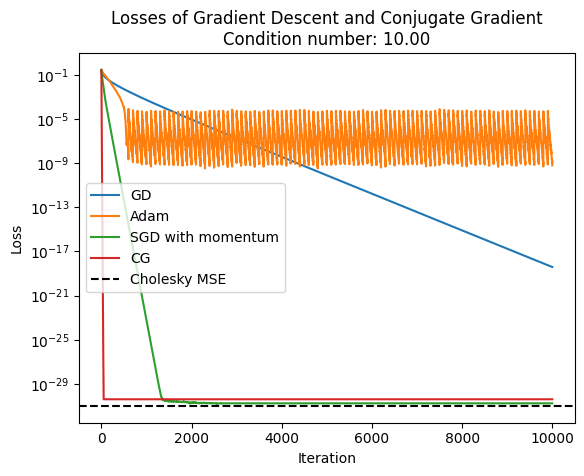

In [130]:
# plot losses (gd) and losses (cg) in different colors 
plt.plot(losses, label='GD')
plt.plot(losses_adam, label='Adam')
plt.plot(losses_momentum, label='SGD with momentum')
plt.plot(cg_mses, label='CG')

# horizontal line at cholesky_mse
plt.axhline(.5*cholesky_mse, color='black', linestyle='--', label='Cholesky MSE')
# log scale
plt.yscale('log')
plt.title(f'Losses of Gradient Descent and Conjugate Gradient\nCondition number: {torch.linalg.cond(K):.2f}')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()

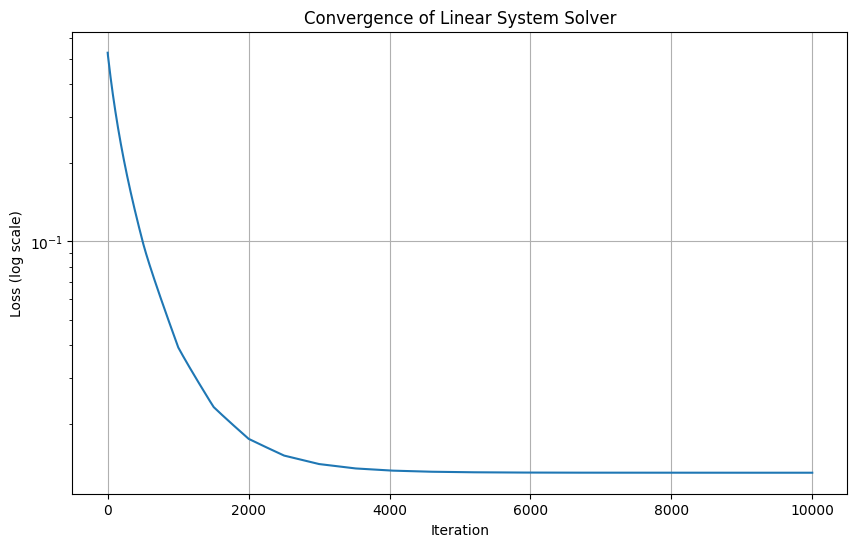

In [38]:
plot_convergence(losses)

In [151]:
losses[-1]

4.706826994608218

In [152]:
verify_solution(K, y, sigma_sq, alpha_sgd, alpha_cholesky.numpy())


Tested Residual: 3.068161e+00
Cholesky Residual: 3.213819e-13
Solution Difference: 3.063319e+01


/tmp/ipykernel_54024/114607194.py:91: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(alpha_tested) - y)
/tmp/ipykernel_54024/114607194.py:97: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(f"Solution Difference: {torch.norm(torch.tensor(alpha_tested) - alpha_cholesky):.6e}")


In [161]:
def verify_solution(system_matrix, rhs, solutions: list[torch.Tensor], names: list[str]):
    """Verify solution quality"""
    # Compute residuals for both solutions
    for solution, name in zip(solutions, names):
        res_tested = torch.norm((system_matrix + sigma_sq * torch.eye(system_matrix.shape[0])) @ 
                        torch.tensor(solution) - rhs)
        print(f"Residual for solution {name}: {res_tested:.6e}")


In [167]:
verify_solution(K + sigma_sq * torch.eye(n, dtype=torch.float64), y, [alpha_sgd, alpha_cg, alpha_cholesky], ["SGD", "CG", "Cholesky"])


Residual for solution SGD: 3.034349e+00
Residual for solution CG: 3.098120e+00
Residual for solution Cholesky: 3.098120e+00


/tmp/ipykernel_54024/942080856.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(solution) - rhs)


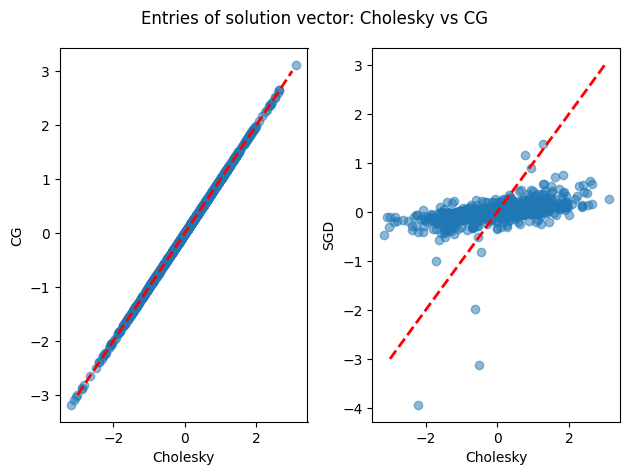

In [179]:
plt.subplot(1, 2, 1)
plt.suptitle("Entries of solution vector: Cholesky vs CG")
plt.scatter(alpha_cholesky, alpha_cg, alpha=0.5)
# diagonal line
plt.plot([-3, 3], [-3, 3], color='red', linestyle="--", linewidth=2)
plt.xlabel("Cholesky")
plt.ylabel("CG")
plt.subplot(1, 2, 2)
plt.scatter(alpha_cholesky, 10*alpha_sgd, alpha=0.5)
plt.plot([-3, 3], [-3, 3], color='red', linestyle="--", linewidth=2)
plt.xlabel("Cholesky")
plt.ylabel("SGD")
plt.tight_layout()
plt.show()


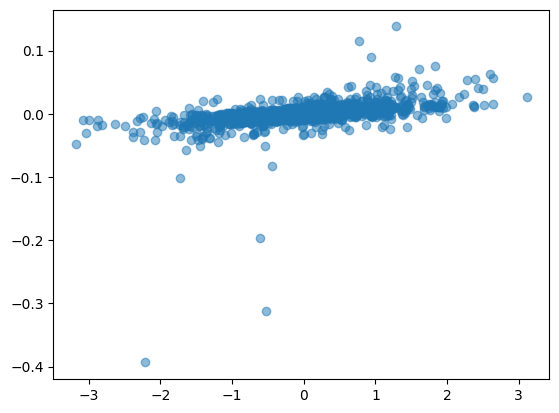

In [171]:
plt.scatter(alpha_cholesky, alpha_sgd, alpha=0.5)